<a href="https://colab.research.google.com/github/niikster/Diploma_YOLOv8-seg/blob/main/YOLO_V8_debris_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Custom instance model training using YOLOv8**

For information about YOLO models: <p>
https://docs.ultralytics.com/models/yolov8/#key-features
<p>


**Install the required libraries:**

Let us start by installing ultralytics library. All other libraries should be pre-installed on colab. If you are working on a local system, please make sure you install matplotlib, Pillow, numpy, Seaborn, and roboflow. You may also want to install pandas and other libraries depending on the task.

In [ ]:
# Install the ultralytics package using pip
!pip install ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image

**Import a model and populate it with pre-trained weights.**
<p>
Here, we are importing an instance segmentation model with weights. For a list of pre-trained models, checkout: https://docs.ultralytics.com/models/yolov8/#key-features

In [ ]:
#Instance
model = YOLO('yolov8x-seg.yaml')  # build a new model from YAML
model = YOLO('yolov8x-seg.pt')  # Transfer the weights from a pretrained model (recommended for training)

100%|██████████| 137M/137M [00:01<00:00, 124MB/s]


**Install Roboflow**
<p>
to directly read our training data. For colab, we are going to find a workaround to handle encoding issues by the platform. In fact, we may encounter encoding issues for other tasks in Colab so let's go ahead and run the following cell.  

In [ ]:
#Withut this Colab is giving an error when installing Roboflow
import locale
locale.getpreferredencoding = lambda: "UTF-8"


In case your annotations are on Roboflow, you can directly import the training data using your API key

In [ ]:
!pip install roboflow --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
# To hide your API key from others, you can use getpass
#from getpass import getpass
#token = getpass('Enter Token Here') #I stored my token in a file on my Google Drive. I will enter it when prompted here.

In [ ]:
# Import your data from Roboflow

%cd /content/


from roboflow import Roboflow
# enter RoboFlow
# check in with your Roboflow token
# insert it here \/\/\/\/
rf = Roboflow(api_key="")
project = rf.workspace("instance-segmentation-for-debris-removal").project("custom-dataset-v3")
dataset = project.version(3).download("yolov8")

/content
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.9, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Custom-dataset-v3-3 in yolov8:: 100%|██████████| 6794/6794 [00:01<00:00, 5906.17it/s]


In [ ]:
# upload your trained model into Roboflow project and use it as Label Assist
#version = project.version(3)
#version.deploy("yolov8-seg", "/content/drive/MyDrive/ColabNotebooks/YOLOv8/200_epochs-3/")

In [ ]:
#Change the working directory to the downloaded data directory and check the yaml file.

%cd /content/Custom-dataset-v3-2

/content/Custom-dataset-v3-2


Let us load the YAML file that contains the names of our classes, number of classes and the directories for train, valid, and test datasets, respectively.

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
path_to_yaml = '/content/Custom-dataset-v3-2/data.yaml'
%cat /content/Custom-dataset-v3-2/data.yaml

names:
- block
- brick
- plank
nc: 3
roboflow:
  license: CC BY 4.0
  project: custom-dataset-v3
  url: https://universe.roboflow.com/instance-segmentation-for-debris-removal/custom-dataset-v3/dataset/2
  version: 2
  workspace: instance-segmentation-for-debris-removal
test: ../test/images
train: /content/Custom-dataset-v3-2/train/images
val: /content/Custom-dataset-v3-2/valid/images


In [ ]:
# define number of classes based on YAML
import yaml
with open(path_to_yaml, 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%ls

data.yaml  README.dataset.txt  README.roboflow.txt  train/  valid/


Resume training

In [ ]:
# Load a model
model = YOLO('/content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-/weights/last.pt')  # load a partially trained model

# Resume training
results = model.train(resume=True)

Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=/content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-/weights/last.pt, data=/content/Custom-dataset-v3-2/data.yaml, epochs=100, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/, name=1200_imgs_100_epochs-, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cl

100%|██████████| 755k/755k [00:00<00:00, 25.2MB/s]


TensorBoard: Start with 'tensorboard --logdir /content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-', view at http://localhost:6006/

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultra

100%|██████████| 6.23M/6.23M [00:00<00:00, 110MB/s]


AMP: checks passed ✅


train: Scanning /content/Custom-dataset-v3-2/train/labels... 3300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3300/3300 [00:04<00:00, 819.66it/s]


train: New cache created: /content/Custom-dataset-v3-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Custom-dataset-v3-2/valid/labels... 99 images, 0 backgrounds, 0 corrupt: 100%|██████████| 99/99 [00:00<00:00, 387.38it/s]

val: New cache created: /content/Custom-dataset-v3-2/valid/labels.cache


Plotting labels to /content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
Resuming training from /content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-/weights/last.pt from epoch 66 to 100 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      15.5G      0.508     0.7783     0.3167     0.9536         25        640: 100%|██████████| 207/207 [05:14<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all         99        363      0.968      0.947      0.985      0.895      0.968      0.947      0.984      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      15.5G     0.5163     0.7902     0.3236     0.9606         19        640: 100%|██████████| 207/207 [05:14<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all         99        363       0.95      0.967      0.982       0.89      0.952      0.969      0.983      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      15.1G     0.5075     0.7658     0.3116     0.9569         21        640: 100%|██████████| 207/207 [05:13<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all         99        363      0.963      0.958      0.983      0.882      0.967      0.961      0.985      0.911



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      15.5G     0.5085     0.7747      0.312     0.9571         24        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all         99        363       0.96       0.95      0.981      0.892      0.963      0.953      0.982       0.91



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.17G     0.4977     0.7671     0.3054     0.9504         28        640: 100%|██████████| 207/207 [05:13<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all         99        363      0.949      0.964      0.983        0.9      0.954      0.969      0.985      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      14.9G     0.4932      0.758     0.3039      0.946         31        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all         99        363      0.935      0.959      0.982       0.89      0.932      0.961      0.982      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      15.3G     0.4955     0.7562     0.3035     0.9475         26        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all         99        363      0.955      0.947      0.981      0.882      0.957      0.949      0.982      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      15.5G     0.4855     0.7311     0.2952     0.9446         34        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all         99        363      0.949      0.956      0.982      0.891      0.949      0.956      0.983      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100       5.3G     0.4902     0.7445     0.2969     0.9424         36        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all         99        363      0.964      0.967      0.984      0.887      0.964      0.967      0.985      0.915



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      15.4G     0.4908     0.7499     0.3031     0.9453         18        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all         99        363      0.973      0.958      0.983      0.893      0.975       0.96      0.984      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      15.5G     0.4856     0.7505     0.2938     0.9381         26        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all         99        363       0.97      0.965      0.983      0.895      0.972      0.966      0.984      0.915



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      15.5G      0.482     0.7308     0.2931     0.9401         32        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all         99        363      0.943       0.97      0.984      0.891      0.943       0.97      0.985      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      15.5G      0.483     0.7354     0.2923     0.9377         23        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all         99        363      0.972      0.947      0.984      0.882      0.974      0.948      0.985      0.912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      15.5G     0.4763     0.7149      0.286     0.9365         34        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all         99        363       0.97      0.957      0.985      0.892      0.968      0.955      0.985      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.23G     0.4679     0.7072     0.2815     0.9282         19        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all         99        363      0.962      0.962      0.984      0.894      0.964      0.964      0.985      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      15.4G     0.4666     0.6985     0.2784     0.9356         18        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all         99        363      0.969      0.962      0.984      0.904      0.969      0.962      0.985      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      15.5G     0.4576     0.6914     0.2729     0.9294         27        640: 100%|██████████| 207/207 [05:13<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all         99        363      0.981      0.956      0.983        0.9      0.983      0.957      0.986       0.92



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      15.5G     0.4618       0.69     0.2733       0.93         30        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all         99        363      0.984      0.964      0.986      0.899      0.987      0.965      0.989       0.92



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      15.4G     0.4585     0.6886     0.2744     0.9284         23        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all         99        363      0.965      0.956      0.984      0.903      0.965      0.956      0.987      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      15.5G     0.4559     0.6796     0.2673     0.9256         15        640: 100%|██████████| 207/207 [05:13<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all         99        363      0.982      0.959      0.988      0.899      0.982      0.959      0.988      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      15.5G      0.458     0.6849     0.2706     0.9258         29        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all         99        363      0.957      0.974      0.986      0.904      0.957      0.974      0.986      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      15.5G     0.4566      0.677     0.2685     0.9283         33        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all         99        363      0.975      0.957      0.984      0.903      0.975      0.957      0.984      0.927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      14.9G     0.4504     0.6741     0.2658     0.9253         34        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all         99        363      0.973      0.956      0.985      0.902      0.975      0.957      0.985      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      15.4G     0.4479     0.6573     0.2603     0.9231         22        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all         99        363      0.979      0.968      0.987      0.899      0.979      0.968      0.989      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100       5.8G      0.448     0.6712     0.2608     0.9214         27        640: 100%|██████████| 207/207 [05:12<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all         99        363      0.993      0.951      0.986      0.901      0.995      0.952      0.989      0.924


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      15.3G     0.3841     0.6303     0.2189     0.8771         20        640: 100%|██████████| 207/207 [05:08<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all         99        363      0.988       0.95      0.986      0.898      0.988       0.95      0.986      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      15.3G     0.3835     0.6187     0.2175     0.8768         13        640: 100%|██████████| 207/207 [05:07<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all         99        363      0.974       0.97      0.986      0.904      0.974       0.97      0.986      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      15.3G     0.3794     0.6174     0.2152     0.8833         17        640: 100%|██████████| 207/207 [05:08<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all         99        363      0.989      0.939      0.987      0.904       0.99      0.941      0.988      0.927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      15.3G     0.3685     0.5892     0.2093     0.8721         11        640: 100%|██████████| 207/207 [05:07<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all         99        363      0.969      0.958      0.986      0.906      0.969      0.958      0.987       0.93



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      15.3G     0.3604     0.5882     0.2042     0.8684         17        640: 100%|██████████| 207/207 [05:08<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all         99        363      0.959      0.967      0.984      0.899      0.961      0.968      0.987      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      15.3G     0.3615     0.5789     0.2018     0.8681         11        640: 100%|██████████| 207/207 [05:07<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all         99        363      0.977      0.955      0.988      0.906      0.977      0.955      0.989      0.931



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      15.3G     0.3587     0.5847     0.2015     0.8626         11        640: 100%|██████████| 207/207 [05:08<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all         99        363      0.954      0.978      0.987        0.9      0.954      0.978      0.987      0.928



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      15.3G     0.3558     0.5772     0.1989     0.8653         16        640: 100%|██████████| 207/207 [05:07<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all         99        363      0.955      0.981      0.988      0.901      0.953      0.979      0.989      0.928



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      15.3G      0.353     0.5754     0.1951     0.8636         12        640: 100%|██████████| 207/207 [05:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all         99        363      0.958      0.977      0.988        0.9      0.958      0.977      0.989       0.93



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      15.4G     0.3524     0.5688     0.1937     0.8633         13        640: 100%|██████████| 207/207 [05:07<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all         99        363      0.951      0.978      0.987        0.9      0.959      0.971      0.988      0.927



35 epochs completed in 3.164 hours.
Optimizer stripped from /content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-/weights/last.pt, 144.0MB
Optimizer stripped from /content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-/weights/best.pt, 144.0MB

Validating /content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-/weights/best.pt...
Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-seg summary (fused): 295 layers, 71723545 parameters, 0 gradients, 343.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


                   all         99        363      0.977      0.955      0.988      0.905      0.977      0.955      0.989      0.931
                 block         99        128      0.994      0.977      0.993       0.95      0.994      0.977      0.993      0.963
                 brick         99        193      0.961      0.943      0.978      0.924      0.961      0.943      0.981      0.935
                 plank         99         42      0.975      0.946      0.992      0.842      0.975      0.946      0.992      0.894
Speed: 0.9ms preprocess, 34.0ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to /content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-


**Train the model**

In [ ]:
#Define a project --> Destination directory for all results
project = "/content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/"
#Define subdirectory for this specific training
name = "1200_imgs_100_epochs-" #note that if you run the training again, it creates a directory: 200_epochs-2

In [ ]:
# Train the model
results = model.train(data=path_to_yaml,
                      project=project,
                      name=name,
                      epochs=100,
                      patience=0, #I am setting patience=0 to disable early stopping.
                      batch=16,
                      imgsz=640)

Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=/content/Custom-dataset-v3-2/data.yaml, epochs=100, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/, name=1200_imgs_100_epochs-, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_

100%|██████████| 755k/755k [00:00<00:00, 82.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 121MB/s]


AMP: checks passed ✅


train: Scanning /content/Custom-dataset-v3-2/train/labels... 3300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3300/3300 [00:03<00:00, 1085.54it/s]


train: New cache created: /content/Custom-dataset-v3-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Custom-dataset-v3-2/valid/labels... 99 images, 0 backgrounds, 0 corrupt: 100%|██████████| 99/99 [00:00<00:00, 463.46it/s]

val: New cache created: /content/Custom-dataset-v3-2/valid/labels.cache


Plotting labels to /content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      14.9G     0.9305      1.763      1.189      1.251         25        640: 100%|██████████| 207/207 [05:45<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]

                   all         99        363      0.585      0.571      0.512      0.347      0.582      0.565      0.489      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      15.5G      1.041      1.902      1.056      1.345         19        640: 100%|██████████| 207/207 [05:42<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]

                   all         99        363       0.78      0.628      0.728      0.521      0.795      0.633      0.732      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      14.9G      1.021      1.852      0.995      1.325         21        640: 100%|██████████| 207/207 [05:41<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all         99        363      0.514      0.524      0.497      0.358      0.518      0.534      0.507      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      15.6G      0.958      1.743     0.8863      1.279         24        640: 100%|██████████| 207/207 [05:40<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all         99        363      0.782      0.735      0.823      0.638      0.792      0.744       0.83      0.662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      15.3G     0.9271      1.661     0.8223      1.251         28        640: 100%|██████████| 207/207 [05:40<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all         99        363      0.825      0.789      0.854      0.665      0.832      0.793      0.856      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100        15G     0.8807      1.552     0.7494      1.218         31        640: 100%|██████████| 207/207 [05:39<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all         99        363      0.811      0.746       0.83      0.623      0.828      0.749      0.837      0.638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      15.1G     0.8766      1.517     0.7247      1.207         26        640: 100%|██████████| 207/207 [05:38<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all         99        363      0.866      0.784      0.872      0.695      0.866      0.784      0.873      0.716



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      15.5G     0.8325      1.462     0.6829      1.179         34        640: 100%|██████████| 207/207 [05:39<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all         99        363      0.873      0.817      0.881       0.72      0.886      0.828      0.894      0.752



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.52G     0.8292      1.437     0.6566      1.167         36        640: 100%|██████████| 207/207 [05:41<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all         99        363      0.849      0.832      0.896      0.731      0.856      0.836      0.896      0.728



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      15.5G     0.8159      1.407     0.6486      1.161         18        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all         99        363      0.859      0.887       0.93      0.779      0.854       0.88      0.924        0.8



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      15.5G     0.7958      1.372     0.6053      1.141         26        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all         99        363       0.93      0.831      0.926      0.772      0.936      0.835      0.928      0.797



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      15.5G      0.777      1.323     0.5811      1.131         32        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all         99        363      0.903      0.848      0.928      0.748      0.908      0.853      0.929      0.798



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      15.5G     0.7788      1.342     0.5824      1.127         23        640: 100%|██████████| 207/207 [05:38<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]

                   all         99        363      0.899      0.856      0.912      0.771      0.903      0.859      0.919      0.804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      15.5G      0.763      1.303     0.5592      1.117         34        640: 100%|██████████| 207/207 [05:38<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all         99        363      0.898      0.826      0.924      0.789      0.902      0.831      0.924       0.81



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.56G     0.7685      1.301     0.5509      1.113         19        640: 100%|██████████| 207/207 [05:38<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all         99        363      0.923      0.844      0.922      0.773      0.905      0.862      0.921      0.796



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      15.5G      0.753      1.281     0.5513      1.111         18        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all         99        363      0.928      0.887      0.946      0.797       0.93      0.889      0.945       0.82



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      15.5G     0.7433      1.254     0.5357        1.1         27        640: 100%|██████████| 207/207 [05:38<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all         99        363      0.918      0.882      0.949      0.804       0.92      0.884       0.95      0.836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      15.5G     0.7372      1.244     0.5282        1.1         30        640: 100%|██████████| 207/207 [05:38<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all         99        363      0.936      0.876      0.954      0.796      0.939      0.878      0.951      0.839



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      15.4G     0.7365      1.248     0.5194      1.098         23        640: 100%|██████████| 207/207 [05:36<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all         99        363      0.957       0.87      0.952      0.816      0.959      0.871      0.954      0.834



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      15.5G     0.7282      1.217     0.5122       1.09         15        640: 100%|██████████| 207/207 [05:39<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all         99        363      0.907      0.852      0.946      0.804      0.916       0.86      0.953      0.831



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.55G      0.729      1.202     0.5129      1.088         29        640: 100%|██████████| 207/207 [05:38<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


                   all         99        363      0.936      0.884      0.961       0.82      0.942      0.887      0.959      0.849

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      15.5G     0.7234      1.218     0.4968      1.085         33        640: 100%|██████████| 207/207 [05:39<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all         99        363      0.954      0.851      0.947       0.81      0.957      0.854       0.95      0.827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.9G     0.7157       1.21     0.4997      1.084         34        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all         99        363       0.96      0.881      0.956      0.821      0.963      0.879      0.956      0.858



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      15.4G     0.7121      1.185     0.4901      1.081         22        640: 100%|██████████| 207/207 [05:38<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all         99        363      0.925      0.927       0.97      0.831       0.93      0.931      0.972       0.87



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.24G     0.7044      1.185     0.4824      1.069         27        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all         99        363      0.946      0.892      0.954      0.831      0.947      0.894      0.958      0.819



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      15.4G     0.6956      1.161     0.4695      1.062         23        640: 100%|██████████| 207/207 [05:36<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all         99        363      0.945      0.932      0.979      0.844      0.948      0.932       0.98      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.32G     0.6881       1.14     0.4642      1.053         18        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all         99        363      0.949      0.885      0.958       0.83       0.95      0.886       0.96      0.864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      15.4G     0.6832      1.133     0.4614      1.053         22        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all         99        363      0.926      0.886      0.949      0.819      0.931       0.89      0.952      0.856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      15.4G      0.687      1.132     0.4591      1.055         19        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all         99        363      0.924      0.946      0.969      0.831      0.924      0.946      0.973      0.867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      15.5G      0.673      1.111     0.4499      1.047         37        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all         99        363       0.95      0.909      0.964       0.83      0.952      0.911      0.964      0.862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      15.4G     0.6672      1.104     0.4478      1.047         36        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all         99        363      0.946       0.92      0.973      0.839      0.961      0.903      0.974       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      15.5G     0.6652      1.103     0.4456       1.04         19        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]

                   all         99        363      0.946      0.917       0.96      0.841      0.946      0.917      0.963      0.873



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.65G     0.6578      1.077     0.4375      1.044         25        640: 100%|██████████| 207/207 [05:38<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all         99        363      0.948      0.911      0.969      0.846       0.95      0.913      0.971      0.861



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      15.5G     0.6513       1.08     0.4363      1.034         27        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all         99        363       0.95      0.911      0.966      0.847      0.939      0.938      0.969       0.87



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      15.5G      0.654      1.096     0.4365      1.036         18        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all         99        363      0.951      0.906      0.975      0.846      0.952      0.906      0.977      0.873



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.57G     0.6487      1.054     0.4323      1.033         26        640: 100%|██████████| 207/207 [05:38<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all         99        363      0.947      0.928      0.974       0.85      0.949       0.93      0.977       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      15.5G     0.6326      1.031     0.4119      1.025         23        640: 100%|██████████| 207/207 [05:38<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all         99        363      0.962      0.887      0.972      0.854      0.964      0.889      0.972      0.866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      15.5G     0.6371      1.036     0.4198      1.026         22        640: 100%|██████████| 207/207 [05:36<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all         99        363      0.929       0.95      0.974      0.855      0.925      0.945      0.964      0.858



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100        15G      0.631      1.031     0.4134      1.023         15        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all         99        363      0.932      0.938      0.974      0.854      0.936      0.939      0.974       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      15.4G     0.6134      1.009     0.3971      1.013         18        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]

                   all         99        363       0.94      0.941      0.973       0.85       0.94      0.941      0.974      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.55G      0.612      1.004     0.4047      1.012         18        640: 100%|██████████| 207/207 [05:38<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all         99        363      0.941      0.948      0.979      0.872      0.943       0.95      0.981      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      14.8G      0.601     0.9629     0.3922      1.005         22        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all         99        363      0.964      0.949      0.979      0.862      0.966      0.951      0.981      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.46G     0.5938     0.9402     0.3853      1.006         24        640: 100%|██████████| 207/207 [05:36<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all         99        363      0.959      0.936      0.974      0.853      0.962      0.939      0.975      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      15.4G     0.5941     0.9417     0.3831      1.005         14        640: 100%|██████████| 207/207 [05:36<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all         99        363      0.944       0.94      0.973       0.85      0.947      0.941      0.973      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      15.5G     0.5796     0.9428     0.3813     0.9971         26        640: 100%|██████████| 207/207 [05:36<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all         99        363      0.961      0.928      0.973      0.862      0.965      0.931      0.975      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      15.3G     0.5788      0.922     0.3742     0.9932         21        640: 100%|██████████| 207/207 [05:36<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all         99        363      0.947      0.921      0.972      0.851      0.952      0.926      0.974      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      14.8G     0.5857     0.9156     0.3768     0.9983         30        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all         99        363      0.965      0.927      0.976      0.874       0.95      0.948      0.976      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.22G     0.5731     0.9048     0.3641     0.9915         27        640: 100%|██████████| 207/207 [05:35<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all         99        363      0.958      0.938      0.976      0.865      0.961      0.942      0.979       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      15.5G     0.5709     0.9193     0.3627     0.9908         25        640: 100%|██████████| 207/207 [05:36<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all         99        363       0.97      0.917      0.979      0.875      0.956      0.933      0.981      0.905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      15.5G     0.5657     0.8879     0.3683      0.987         30        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all         99        363      0.961      0.937      0.977      0.865      0.963      0.938      0.978      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      15.4G     0.5577     0.8898     0.3631     0.9825         12        640: 100%|██████████| 207/207 [05:35<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


                   all         99        363      0.989      0.925      0.978      0.882      0.989      0.925       0.98      0.905

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      15.5G     0.5603     0.8748     0.3575     0.9836         26        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all         99        363      0.954      0.948      0.978      0.876      0.959      0.949      0.979      0.889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      15.5G     0.5527     0.8721      0.353     0.9812         23        640: 100%|██████████| 207/207 [05:36<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all         99        363      0.961      0.943       0.98      0.878      0.964      0.934       0.98      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.88G     0.5514     0.8599      0.357     0.9806         24        640: 100%|██████████| 207/207 [05:36<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all         99        363      0.969      0.929      0.977      0.875      0.972      0.931      0.979      0.907



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.53G     0.5496     0.8552     0.3501     0.9791         24        640: 100%|██████████| 207/207 [05:35<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all         99        363      0.955      0.959      0.982      0.877      0.947      0.966      0.983      0.913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      15.3G      0.549      0.848     0.3474     0.9724         23        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all         99        363      0.967      0.933       0.98      0.877      0.967      0.933       0.98      0.911



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      15.5G     0.5362     0.8382     0.3428     0.9705         28        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all         99        363      0.965      0.922      0.977      0.875      0.968      0.926      0.977      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.84G      0.536     0.8254     0.3404     0.9671         18        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all         99        363      0.965      0.929      0.978      0.885      0.967       0.93       0.98      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      15.5G     0.5389     0.8433     0.3449     0.9687          9        640: 100%|██████████| 207/207 [05:36<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all         99        363      0.946      0.943      0.979      0.875      0.948      0.944       0.98      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      15.5G     0.5278       0.81      0.334     0.9669         13        640: 100%|██████████| 207/207 [05:35<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all         99        363      0.946      0.936      0.969      0.865       0.95      0.939      0.974      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      15.5G     0.5281     0.8162     0.3301     0.9616         20        640: 100%|██████████| 207/207 [05:36<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all         99        363      0.949      0.957      0.979      0.881      0.951      0.959       0.98      0.908



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      15.4G     0.5301     0.8185     0.3339     0.9655         22        640: 100%|██████████| 207/207 [05:36<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all         99        363       0.93      0.956      0.979      0.875      0.931      0.956      0.981      0.903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.31G     0.5287     0.8221     0.3294     0.9648         11        640: 100%|██████████| 207/207 [05:37<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all         99        363      0.948      0.921      0.974      0.871      0.956      0.929      0.979      0.904



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      15.5G     0.5217     0.7932     0.3238     0.9605         20        640: 100%|██████████| 207/207 [05:36<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all         99        363      0.949      0.954      0.983      0.888      0.951      0.956      0.984      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      15.5G     0.5204     0.8034     0.3197     0.9647         14        640: 100%|██████████| 207/207 [05:36<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all         99        363      0.953      0.951      0.983      0.895      0.957      0.956      0.986      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      15.5G     0.5074     0.7812     0.3157     0.9603         74        640:  38%|███▊      | 78/207 [02:08<03:32,  1.65s/it]

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/ColabNotebooks/YOLOv8/small/100_epochs-

All training curves, metrics, and other results are stored as images in the 'runs' directory. Let us open a couple of these images.

In [ ]:
from IPython.display import Image

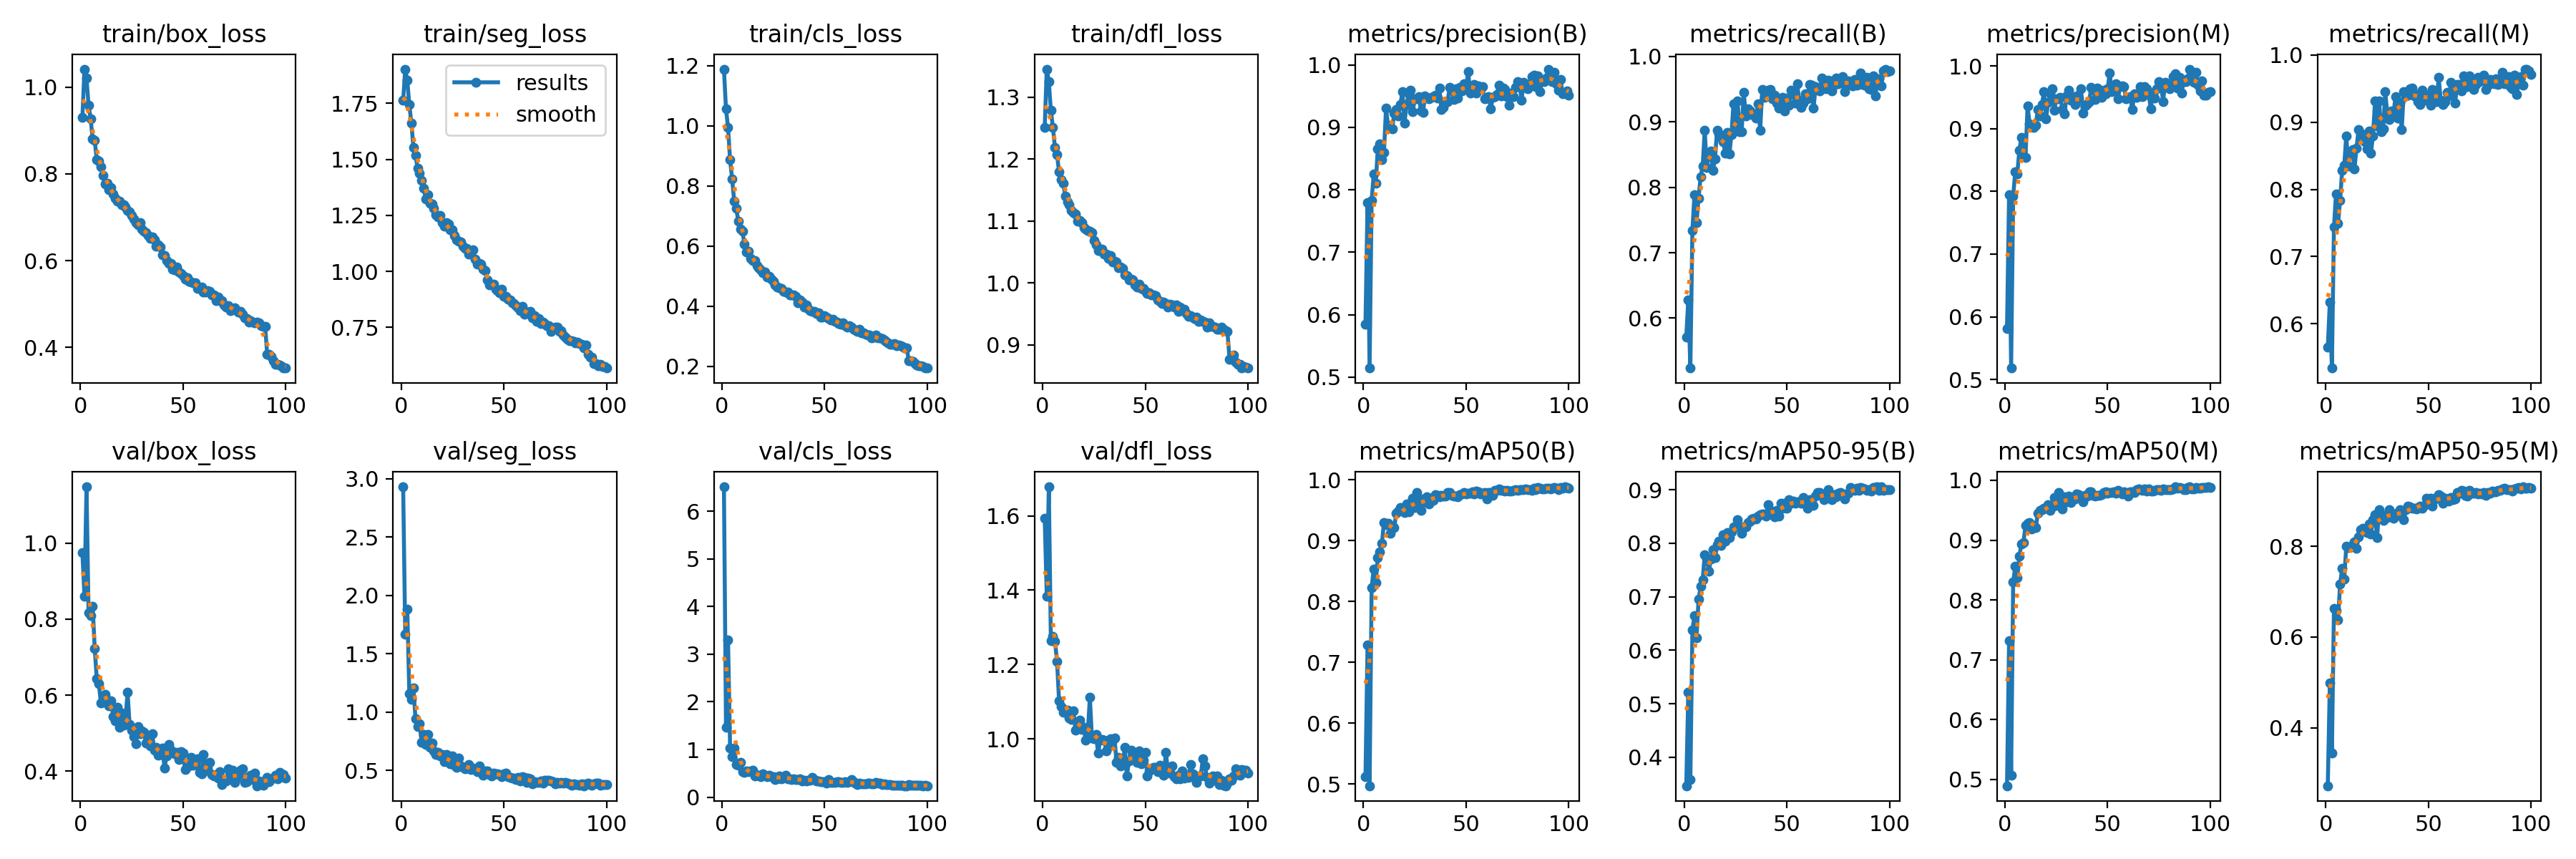

In [ ]:
Image("/content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-/results.png")

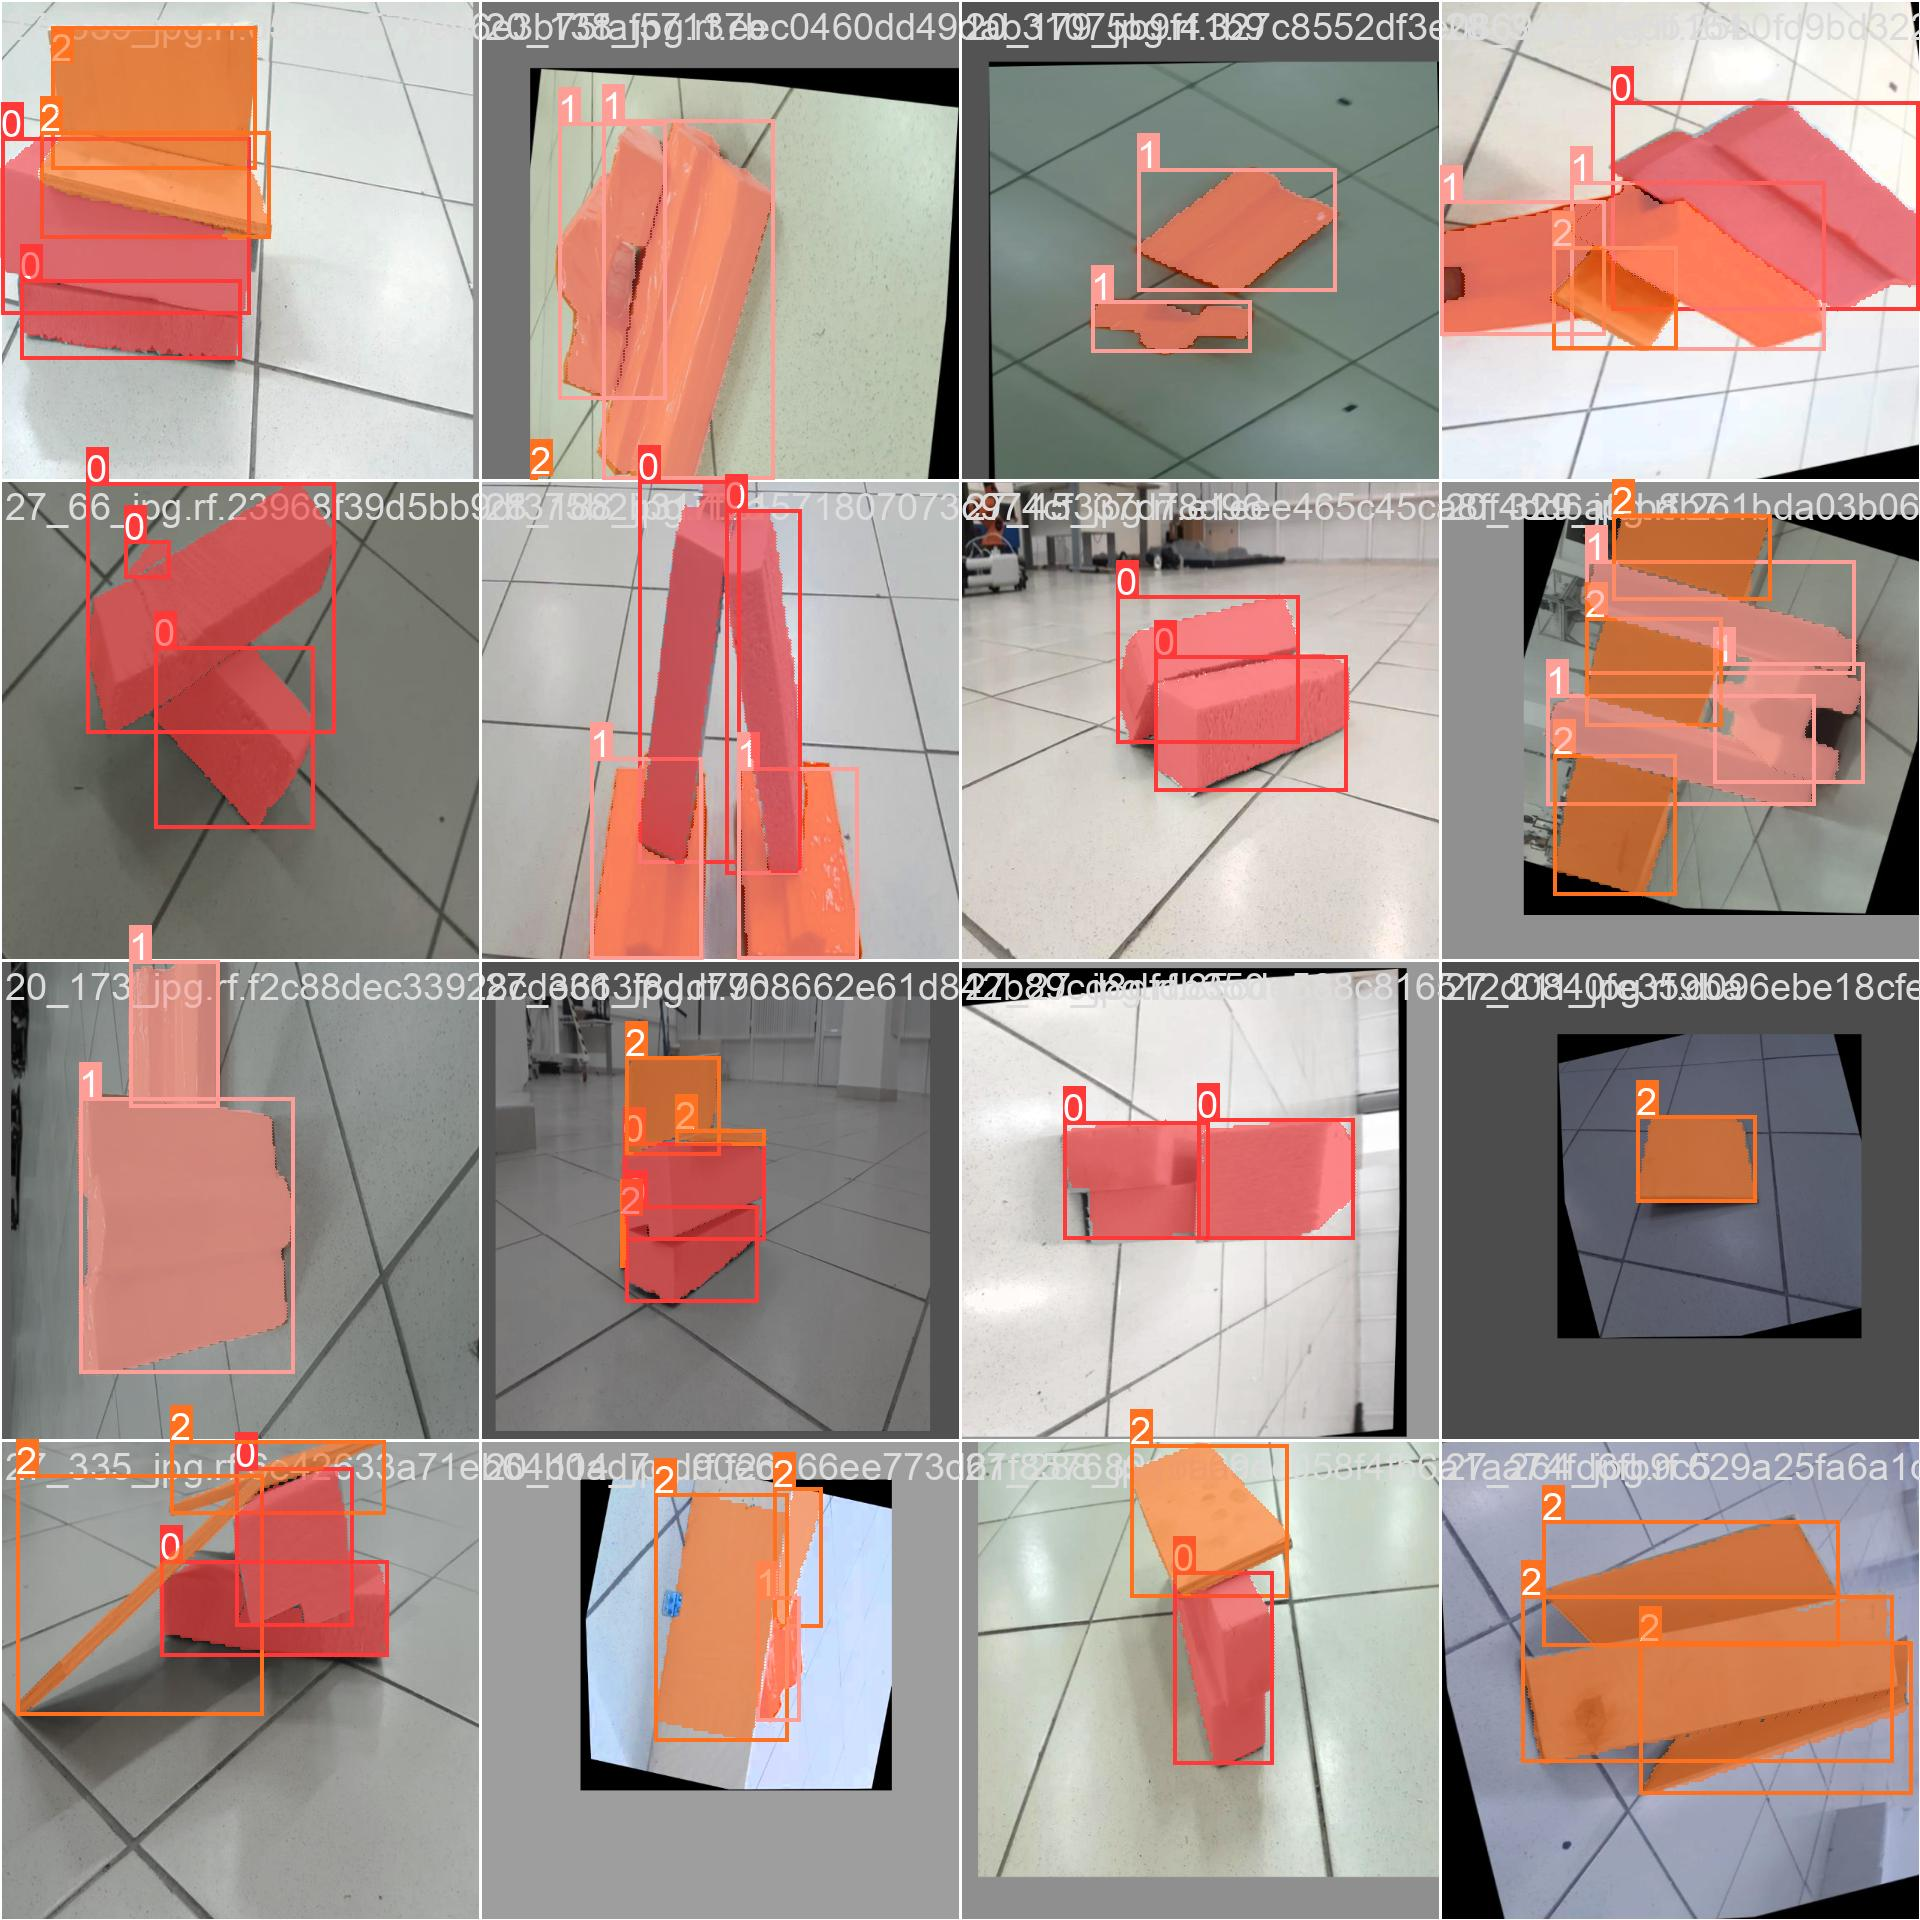

In [ ]:
Image(filename="/content/drive/MyDrive/ColabNotebooks/YOLOv8/nano/100_epochs-/train_batch9361.jpg", width=900)

**Run inference**

Now that our model is trained, we can use it for inference.

In [ ]:
#List the saved models in 'runs' directory. Note that you will see multiple 'train' subdirectories numbered 1, 2, 3, etc. The exact number depends on the number of epochs.
%ls /content/drive/MyDrive/ColabNotebooks/YOLOv8/small/100_epochs-/weights

best.pt  last.pt


In [ ]:
nano_model = YOLO('/content/drive/MyDrive/ColabNotebooks/YOLOv8/nano/100_epochs-/weights/best.pt')

# Validate the model
metrics = nano_model.val(data = '/content/Custom-dataset-v3-3/data.yaml')  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95(B)
metrics.box.map50  # map50(B)
metrics.box.map75  # map75(B)
metrics.box.maps   # a list contains map50-95(B) of each category
metrics.seg.map    # map50-95(M)
metrics.seg.map50  # map50(M)
metrics.seg.map75  # map75(M)
metrics.seg.maps   # a list contains map50-95(M) of each category

Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258649 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /content/Custom-dataset-v3-3/test/labels... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<00:00, 1106.79it/s]

val: WARNING ⚠️ /content/Custom-dataset-v3-3/test/images/test_008_jpg.rf.4769c7dd55624be0e31c7f84d2d345a2.jpg: 1 duplicate labels removed


val: New cache created: /content/Custom-dataset-v3-3/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:11<00:00,  1.11it/s]


                   all        206       1239      0.886      0.751      0.867      0.713      0.886      0.748      0.864      0.679
                 block        206        507      0.925      0.629      0.824      0.642       0.93      0.631      0.824      0.613
                 brick        206        433      0.869      0.822      0.889      0.749      0.863      0.815      0.881      0.716
                 plank        206        299      0.863      0.801      0.887      0.748      0.864      0.799      0.885      0.707
Speed: 4.0ms preprocess, 7.5ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/val4


array([    0.61274,     0.71585,     0.70701])

In [ ]:
small_model = YOLO('/content/drive/MyDrive/ColabNotebooks/YOLOv8/small/100_epochs-/weights/best.pt')

# Validate the model
metrics = small_model.val(data = '/content/Custom-dataset-v3-3/data.yaml',
                          save_hybrid = True,
                          save_json = True,
                          split = 'test')
metrics.seg.maps   # a list contains map50-95(M) of each category

Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11780761 parameters, 0 gradients, 42.4 GFLOPs


val: Scanning /content/Custom-dataset-v3-3/test/labels.cache... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/Custom-dataset-v3-3/test/images/test_008_jpg.rf.4769c7dd55624be0e31c7f84d2d345a2.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


                   all        206       1239          1      0.998      0.995      0.995     0.0404     0.0446     0.0214    0.00926
                 block        206        507          1          1      0.995      0.995     0.0353     0.0375     0.0183    0.00706
                 brick        206        433          1      0.993      0.995      0.995      0.068     0.0762     0.0366     0.0145
                 plank        206        299          1          1      0.995      0.995     0.0179     0.0201    0.00915    0.00624
Speed: 4.9ms preprocess, 12.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Saving runs/segment/val/predictions.json...
Results saved to runs/segment/val


array([  0.0070608,    0.014494,     0.00624])

In [ ]:
%cd /content/runs/
!zip -r dataset.zip segment/
from google.colab import files
files.download('dataset.zip')

/content/runs
  adding: segment/ (stored 0%)
  adding: segment/val/ (stored 0%)
  adding: segment/val/BoxP_curve.png (deflated 13%)
  adding: segment/val/val_batch2_labels.jpg (deflated 10%)
  adding: segment/val/BoxR_curve.png (deflated 12%)
  adding: segment/val/val_batch0_labels.jpg (deflated 10%)
  adding: segment/val/MaskF1_curve.png (deflated 11%)
  adding: segment/val/val_batch1_pred.jpg (deflated 8%)
  adding: segment/val/confusion_matrix.png (deflated 30%)
  adding: segment/val/MaskPR_curve.png (deflated 11%)
  adding: segment/val/val_batch2_pred.jpg (deflated 9%)
  adding: segment/val/val_batch0_pred.jpg (deflated 9%)
  adding: segment/val/BoxPR_curve.png (deflated 11%)
  adding: segment/val/MaskR_curve.png (deflated 12%)
  adding: segment/val/confusion_matrix_normalized.png (deflated 29%)
  adding: segment/val/BoxF1_curve.png (deflated 12%)
  adding: segment/val/val_batch1_labels.jpg (deflated 9%)
  adding: segment/val/MaskP_curve.png (deflated 13%)
  adding: segment/val4/ (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

You can load the best model or the latest. I am picking the latest.

In [ ]:
# my_new_model = YOLO('/content/drive/MyDrive/ColabNotebooks/YOLOv8/extra_large/1200_imgs_100_epochs-/weights/best.pt')
my_new_model = YOLO('/content/drive/MyDrive/ColabNotebooks/YOLOv8/nano/100_epochs-/weights/best.pt')

# Validate the model
metrics = my_new_model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95(B)
metrics.box.map50  # map50(B)
metrics.box.map75  # map75(B)
metrics.box.maps   # a list contains map50-95(B) of each category
metrics.seg.map    # map50-95(M)
metrics.seg.map50  # map50(M)
metrics.seg.map75  # map75(M)
metrics.seg.maps   # a list contains map50-95(M) of each category



Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-seg summary (fused): 295 layers, 71723545 parameters, 0 gradients, 343.7 GFLOPs


val: Scanning /content/Custom-dataset-v3-2/valid/labels.cache... 99 images, 0 backgrounds, 0 corrupt: 100%|██████████| 99/99 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


                   all         99        363      0.977      0.955      0.988      0.904      0.977      0.955      0.989      0.929
                 block         99        128      0.994      0.977      0.993      0.947      0.994      0.977      0.993      0.962
                 brick         99        193       0.96      0.943      0.979      0.924       0.96      0.943      0.981      0.933
                 plank         99         42      0.975      0.946      0.992       0.84      0.975      0.946      0.992      0.892
Speed: 0.4ms preprocess, 84.5ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/segment/val


array([    0.96166,      0.9329,     0.89217])

In [ ]:
import glob
# Get data file names
path = '/content/drive/MyDrive/test'
filenames = glob.glob(path + "/*.jpg")

print(filenames)

['/content/drive/MyDrive/test/test_000.jpg', '/content/drive/MyDrive/test/test_002.jpg', '/content/drive/MyDrive/test/test_001.jpg', '/content/drive/MyDrive/test/test_004.jpg', '/content/drive/MyDrive/test/test_005.jpg', '/content/drive/MyDrive/test/test_003.jpg', '/content/drive/MyDrive/test/test_009.jpg', '/content/drive/MyDrive/test/test_007.jpg', '/content/drive/MyDrive/test/test_008.jpg', '/content/drive/MyDrive/test/test_006.jpg', '/content/drive/MyDrive/test/test_010.jpg', '/content/drive/MyDrive/test/test_011.jpg', '/content/drive/MyDrive/test/test_012.jpg', '/content/drive/MyDrive/test/test_013.jpg', '/content/drive/MyDrive/test/test_014.jpg', '/content/drive/MyDrive/test/test_015.jpg', '/content/drive/MyDrive/test/test_016.jpg', '/content/drive/MyDrive/test/test_017.jpg', '/content/drive/MyDrive/test/test_022.jpg', '/content/drive/MyDrive/test/test_020.jpg', '/content/drive/MyDrive/test/test_019.jpg', '/content/drive/MyDrive/test/test_018.jpg', '/content/drive/MyDrive/test/te

Load an image and perform inference (segmentation).

In [ ]:
%cd /content
# from random import choice
# new_image = choice(filenames)
# new_results = my_new_model.predict(new_image, conf=0.6)  #Adjust conf threshold
for image in filenames:
  new_results = my_new_model.predict(image, conf=0.7, save_txt=True)


/content

image 1/1 /content/drive/MyDrive/test/test_000.jpg: 640x640 2 blocks, 2 bricks, 3 planks, 84.6ms
Speed: 2.3ms preprocess, 84.6ms inference, 33.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict
1 label saved to runs/segment/predict/labels

image 1/1 /content/drive/MyDrive/test/test_002.jpg: 640x640 1 block, 1 brick, 2 planks, 84.8ms
Speed: 1.6ms preprocess, 84.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict
2 labels saved to runs/segment/predict/labels

image 1/1 /content/drive/MyDrive/test/test_001.jpg: 640x640 3 bricks, 2 planks, 80.8ms
Speed: 2.2ms preprocess, 80.8ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict
3 labels saved to runs/segment/predict/labels

image 1/1 /content/drive/MyDrive/test/test_004.jpg: 640x640 2 blocks, 3 bricks, 2 planks, 79.4ms
Speed: 1.9ms preprocess, 79.4ms inference, 5.7ms postprocess per ima

In [ ]:

%cd /content/runs/segment/
!zip -r dataset.zip predict/
from google.colab import files
files.download('dataset.zip')

/content/runs/segment
  adding: predict/ (stored 0%)
  adding: predict/labels/ (stored 0%)
  adding: predict/labels/test_176.txt (deflated 79%)
  adding: predict/labels/test_097.txt (deflated 79%)
  adding: predict/labels/test_030.txt (deflated 78%)
  adding: predict/labels/test_085.txt (deflated 79%)
  adding: predict/labels/test_125.txt (deflated 78%)
  adding: predict/labels/test_034.txt (deflated 79%)
  adding: predict/labels/test_090.txt (deflated 79%)
  adding: predict/labels/test_120.txt (deflated 79%)
  adding: predict/labels/test_183.txt (deflated 79%)
  adding: predict/labels/test_008.txt (deflated 80%)
  adding: predict/labels/test_086.txt (deflated 79%)
  adding: predict/labels/test_182.txt (deflated 79%)
  adding: predict/labels/test_087.txt (deflated 79%)
  adding: predict/labels/test_163.txt (deflated 79%)
  adding: predict/labels/test_187.txt (deflated 79%)
  adding: predict/labels/test_145.txt (deflated 79%)
  adding: predict/labels/test_166.txt (deflated 78%)
  adding

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content

image 1/1 /content/drive/MyDrive/test/test_109.jpg: 640x640 3 blocks, 3 bricks, 3 planks, 131.8ms
Speed: 2.1ms preprocess, 131.8ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict
206 labels saved to runs/segment/predict/labels


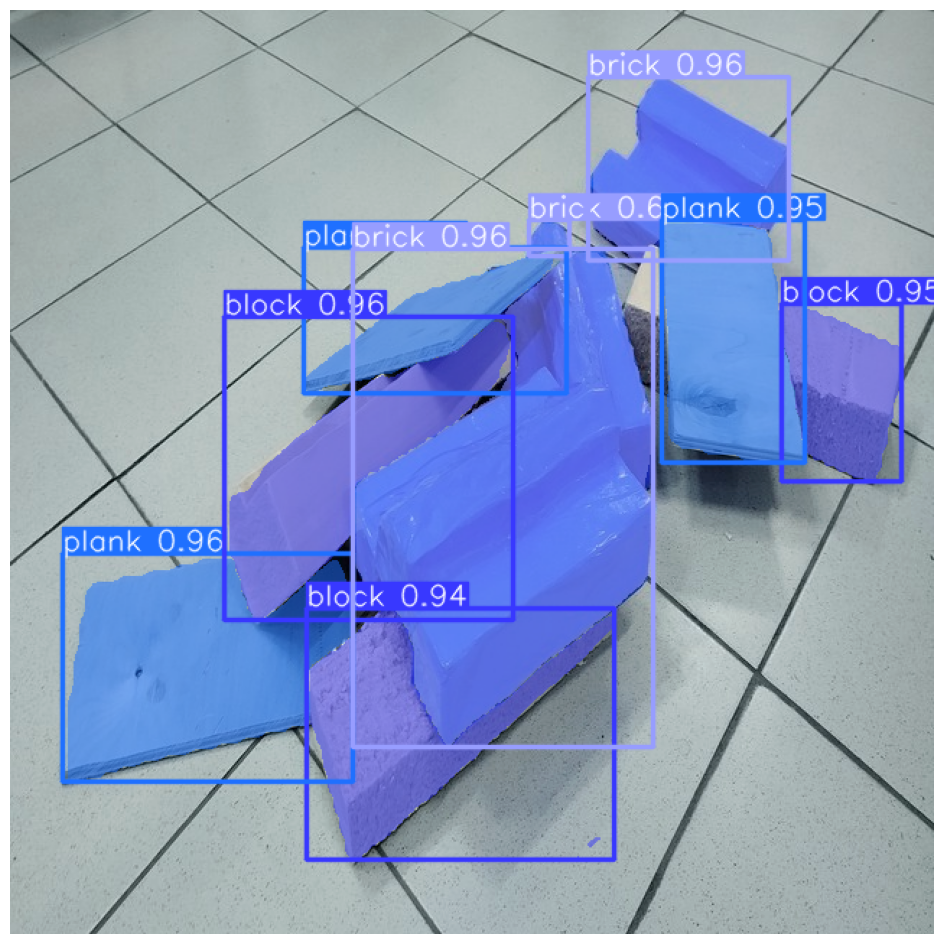

In [ ]:
%cd /content
from random import choice
new_image = choice(filenames)
new_results = my_new_model.predict(new_image, conf=0.6)  #Adjust conf threshold
new_result_array = new_results[0].plot() # 0 stands for the first image in series, 1 for the seccond, etc...
plt.figure(figsize=(12, 12))
plt.axis('off') # Turn off axis labels
plt.imshow(new_result_array)

The results are stored in a variable 'new_results'. Since we only have one image for segmentation, we will only have one set of results. Therefore, let us work with that one result.

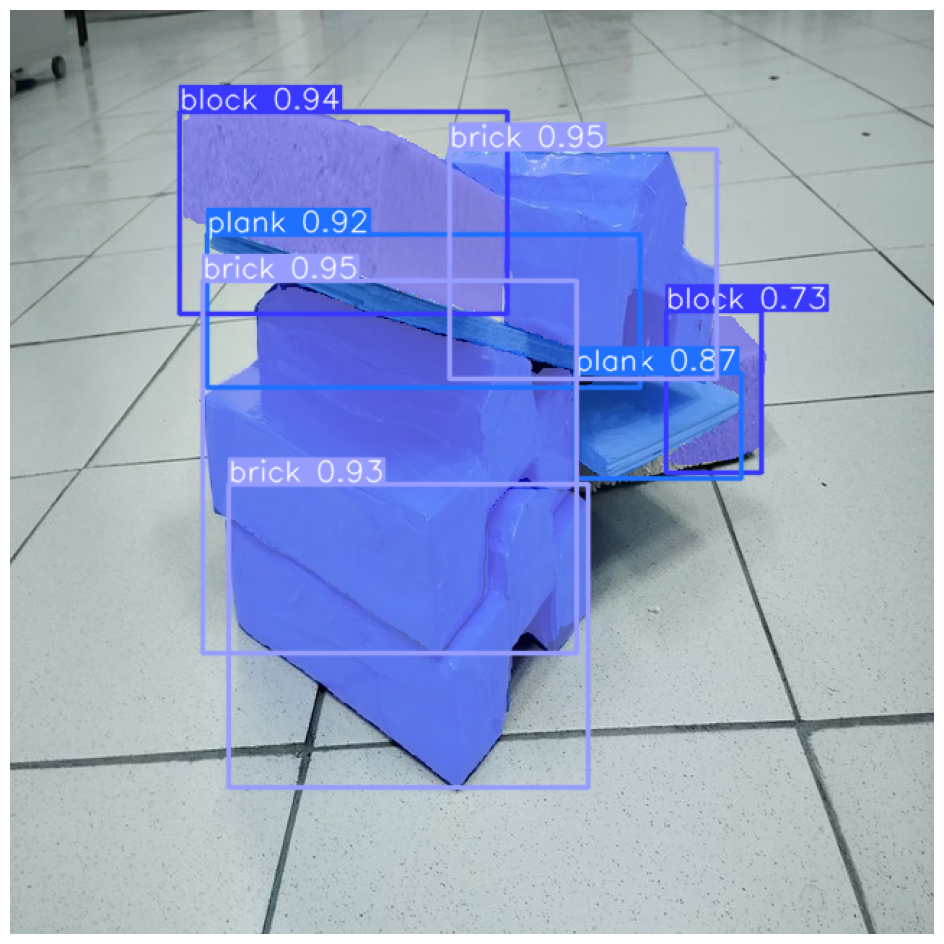

In [ ]:
new_result_array = new_results[0].plot()
plt.figure(figsize=(12, 12))
plt.axis('off') # Turn off axis labels
plt.imshow(new_result_array)

**Extracting bounding boxes and segmented masks from the result**

In [ ]:
new_result = new_results[0]

In [ ]:
new_result

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'block', 1: 'brick', 2: 'plank'}
obb: None
orig_img: array([[[155, 159, 154],
        [154, 158, 153],
        [157, 161, 156],
        ...,
        [165, 167, 167],
        [165, 167, 167],
        [165, 167, 167]],

       [[155, 159, 154],
        [155, 159, 154],
        [156, 160, 155],
        ...,
        [165, 167, 167],
        [165, 167, 167],
        [165, 167, 167]],

       [[155, 158, 156],
        [155, 158, 156],
        [154, 157, 155],
        ...,
        [165, 167, 167],
        [165, 167, 167],
        [164, 166, 166]],

       ...,

       [[161, 160, 156],
        [161, 160, 156],
        [161, 160, 156],
        ...,
        [151, 153, 153],
        [151, 153, 153],
        [152, 154, 154]],

       [[160, 159, 155],
        [160, 159, 155],
        [161, 160, 156],
        ...,
     

**Extracting bounding polygons** <p>
Use 'Masks.xyn' for segments (normalized) and 'Masks.xy' for segments (pixels)

In [ ]:
new_result.masks.xyn

[array([[    0.22656,      0.2125],
        [      0.225,     0.21406],
        [    0.22344,     0.21406],
        [    0.22031,     0.21719],
        [    0.22031,     0.21875],
        [    0.21875,     0.22031],
        [    0.21875,     0.22187],
        [    0.21406,     0.22656],
        [    0.21406,     0.22813],
        [     0.2125,     0.22969],
        [     0.2125,     0.23125],
        [    0.21094,     0.23281],
        [    0.21094,     0.23438],
        [    0.20937,     0.23594],
        [    0.20781,     0.23594],
        [    0.20781,      0.2375],
        [        0.2,     0.24531],
        [        0.2,     0.24688],
        [    0.19688,        0.25],
        [    0.19531,        0.25],
        [    0.19375,     0.25156],
        [    0.19375,     0.25313],
        [    0.18906,     0.25781],
        [    0.18906,     0.25938],
        [    0.18594,      0.2625],
        [    0.18594,     0.26406],
        [    0.18125,     0.26875],
        [    0.18125,     0.

**Extracting segmented masks**

In [ ]:
extracted_masks = new_result.masks.data

In [ ]:
extracted_masks.shape

torch.Size([4, 640, 640])

Push the mask to cpu (from GPU) and convert to numpy array for easy plotting.

In [ ]:
masks_array = extracted_masks.cpu().numpy()

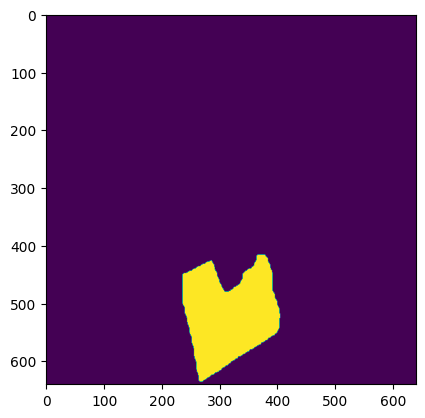

In [ ]:
plt.imshow(masks_array[0])

**Extracting labels for each class**

In [ ]:
class_names = new_result.names.values()
class_names

dict_values(['block', 'brick', 'plank'])

In [ ]:
# Extract the boxes, which likely contain class IDs
detected_boxes = new_result.boxes.data
# Extract class IDs from the detected boxes
class_labels = detected_boxes[:, -1].int().tolist()
# Initialize a dictionary to hold masks by class
masks_by_class = {name: [] for name in new_result.names.values()}

# Iterate through the masks and class labels
for mask, class_id in zip(extracted_masks, class_labels):
    class_name = new_result.names[class_id]  # Map class ID to class name
    masks_by_class[class_name].append(mask.cpu().numpy())

In [ ]:
for class_name, masks in masks_by_class.items():
    print(f"Class Name: {class_name}, Number of Masks: {len(masks)}")


Class Name: block, Number of Masks: 2
Class Name: brick, Number of Masks: 2
Class Name: plank, Number of Masks: 0


**Extracting masks for a specific class**

In [ ]:
block_masks = masks_by_class['block']
brick_masks = masks_by_class['brick']
plank_masks = masks_by_class['plank']

In [ ]:
# Extract the original image
orig_img = new_result.orig_img

In [ ]:

orig_img.shape

(640, 640, 3)

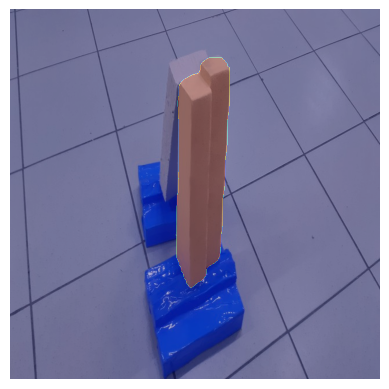

In [ ]:
# Display the original image
plt.imshow(orig_img, cmap='gray')

# Overlay the mask with some transparency
#plt.imshow(alpha_granule_masks[1], cmap='jet', alpha=0.3)
plt.imshow(block_masks[0], cmap='jet', alpha=0.3)
plt.axis('off') # Turn off axis labels
plt.show()

**Calculating region properties for all objects and saving to a csv file.**

In [ ]:
import pandas as pd
from skimage.measure import regionprops

# Initialize a list to store the properties
props_list = []

# Iterate through all classes
for class_name, masks in masks_by_class.items():
    # Iterate through the masks for this class
    for mask in masks:
        # Convert the mask to an integer type if it's not already
        mask = mask.astype(int)

        # Apply regionprops to the mask
        props = regionprops(mask)

        # Extract the properties you want (e.g., area, perimeter) and add them to the list
        for prop in props:
            area = prop.area
            perimeter = prop.perimeter
            # Add other properties as needed

            # Append the properties and class name to the list
            props_list.append({'Class Name': class_name, 'Area': area, 'Perimeter': perimeter})

# Convert the list of dictionaries to a DataFrame
props_df = pd.DataFrame(props_list)

# Now props_df contains the properties and class names for all regions

# Save the DataFrame to a CSV file
props_df.to_csv('/content/drive/MyDrive/ColabNotebooks/YOLOv8/nano/YOLOv8_object_properties.csv', index=False)

In [ ]:
props_df

,Class Name,Area,Perimeter
0,block,29317,904.090404
1,block,8131,619.865007
2,brick,23481,751.955411
3,brick,6782,411.852814


**Plotting results**

In [ ]:
import seaborn as sns


**Swarm plot**

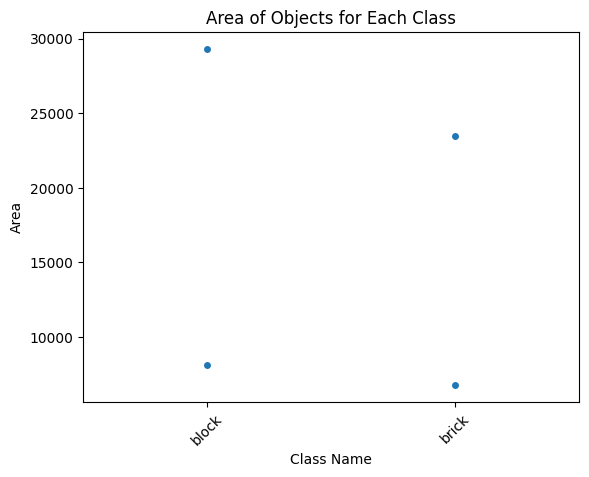

In [ ]:

# Create the swarm plot with Seaborn
sns.swarmplot(x='Class Name', y='Area', data=props_df)

# Add labels and a title
plt.xlabel('Class Name')
plt.ylabel('Area')
plt.title('Area of Objects for Each Class')

# Rotate the x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

**Box Plot**

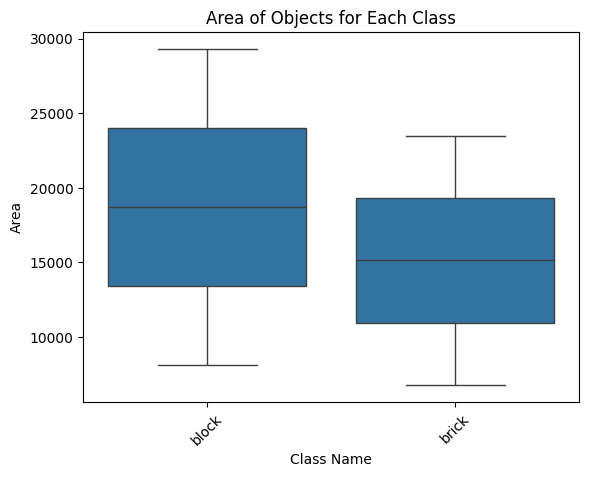

In [ ]:
sns.boxplot(x='Class Name', y='Area', data=props_df)
# Add labels and a title
plt.xlabel('Class Name')
plt.ylabel('Area')
plt.title('Area of Objects for Each Class')

# Rotate the x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

**Export model to ONNX for deployment.**

In [ ]:
# Export the model
my_new_model.export(format='onnx', imgsz=[800,800])
